# CNN analysis

- Task:
  - Compare the performance of a small CNN (LeNet-5) with the results you got for PCA, LDA, and SVM using the Olivetti faces dataset

- Evaluation scenarios:
  - Use 20% of the images for training and 80% for testing
  - Use 50% of the images for training and 50% for testing
  - Use 80% of the images for training and 20% for testing
  - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
  - Plot CMC curve and confusion matrix for each combination of scenario

- Discussion:
  - Is CNN better than PCA/LDA/SVM?
  - Is there a clear difference in performance for different train/test data splits?
  - Can data augmentation improve the results?

## Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"*There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


In [101]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np   

# Get the dataset

In [102]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

(400, 64, 64)


# Split the dataset

In [103]:
def split_dataset(training_percentage):
  N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
  gallery_indices = []
  probe_indices = []
  for i in range(N_IDENTITIES):
    indices = list(np.where(faces.target == i)[0])
    total = len(indices)
    # use the first GALLERY_SIZE images per individual for training, the rest for testing
    GALLERY_SIZE = (total * training_percentage) // 100
    gallery_indices += indices[:GALLERY_SIZE]
    probe_indices += indices[GALLERY_SIZE:]

  X_train = faces.images[gallery_indices].reshape(-1, img_height, img_width, 1) 
  y_train = faces.target[gallery_indices]
  X_test = faces.images[probe_indices].reshape(-1, img_height, img_width, 1)  
  y_test = faces.target[probe_indices]

  print(X_train.shape, X_test.shape)
  return X_train, y_train, X_test, y_test

In [104]:
X_train, y_train, X_test, y_test = split_dataset(20)

(80, 64, 64, 1) (320, 64, 64, 1)


# Visualize the splits

In [105]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
      else:
        row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
    cv2_imshow(row)

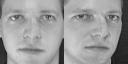

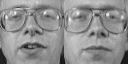

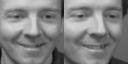

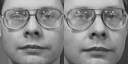

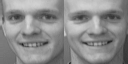

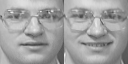

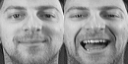

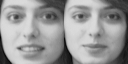

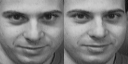

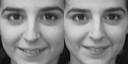

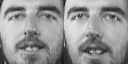

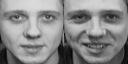

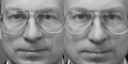

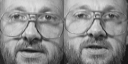

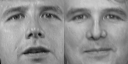

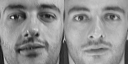

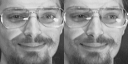

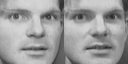

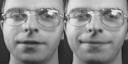

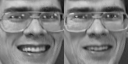

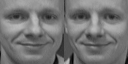

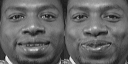

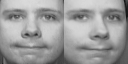

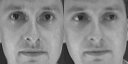

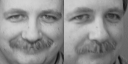

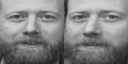

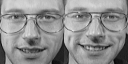

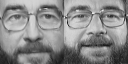

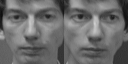

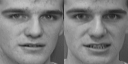

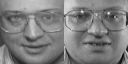

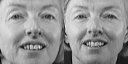

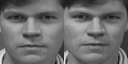

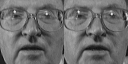

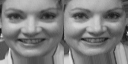

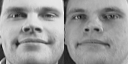

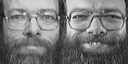

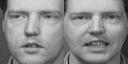

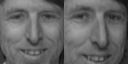

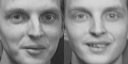

In [106]:
show_images(X_train, 40, 2)

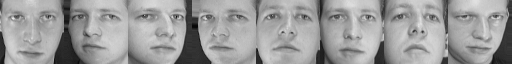

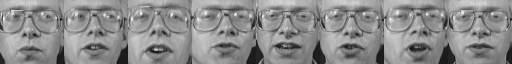

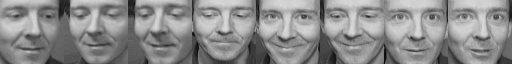

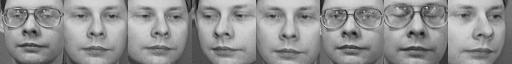

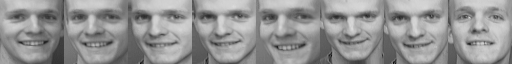

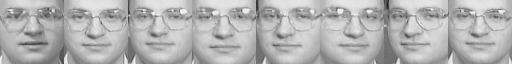

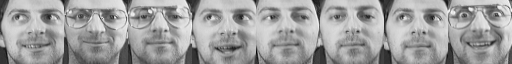

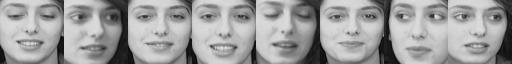

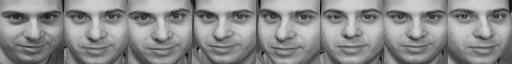

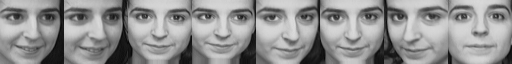

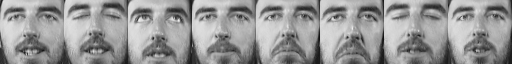

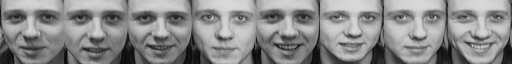

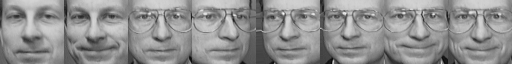

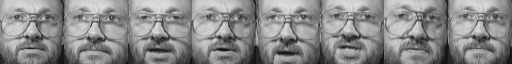

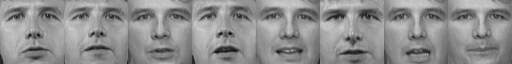

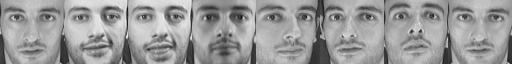

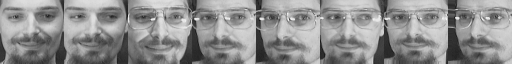

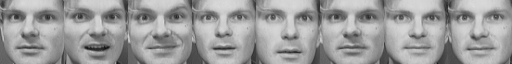

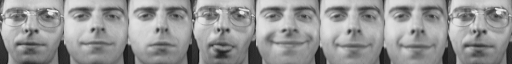

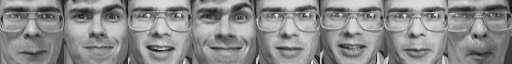

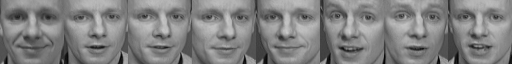

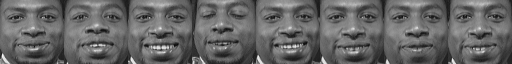

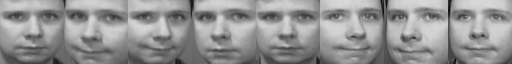

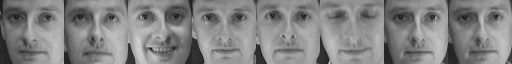

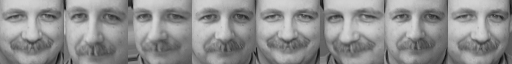

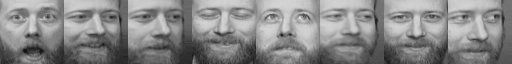

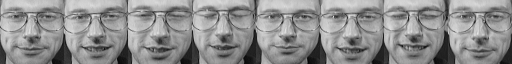

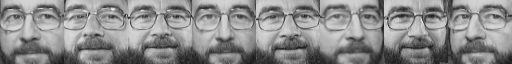

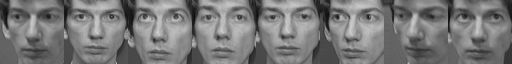

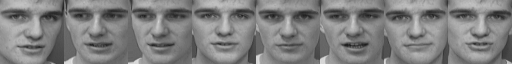

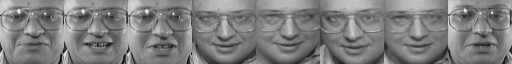

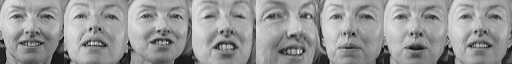

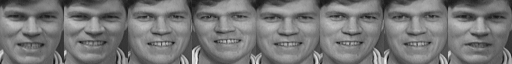

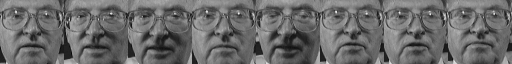

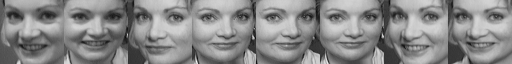

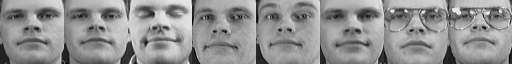

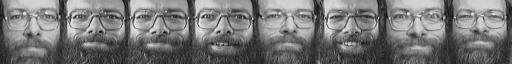

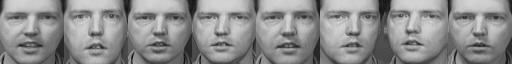

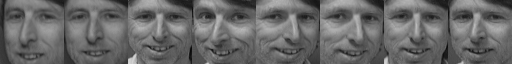

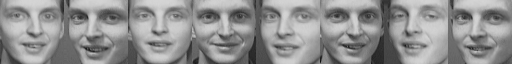

In [107]:
show_images(X_test, 40, 10 - 2)

# Run the experiments

Here is the code I used to get the results below!

**Import libraries**

In [108]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

**Confusion Matrix**

In [109]:
from sklearn.metrics import confusion_matrix
def gen_confusion_matrix(y_t, y_p):
  plt.rcParams["figure.figsize"] = (20,20)
  mat = confusion_matrix(y_t, y_p)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
  plt.xlabel('true label')
  plt.ylabel('predicted label');

**CMC**

In [110]:
def plot_CMC(ysimilarity, ytarget):
  plt.rcParams["figure.figsize"] = (20,20)
  assert len(ysimilarity) == len(ytarget)
  CMC = {}
  for i in range(len(ysimilarity)):
    # get similarity for the correct class
    genuine_sim = ysimilarity[i][ytarget[i]]
    # count how many incorrect classes have higher similarity
    rank = 1
    for j, sim in enumerate(ysimilarity[i]):
      if j != ytarget[i]:
        if sim >= genuine_sim:
          rank += 1
    # save rank
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  # cumulative sum to create CMC
  N = []
  rankN = []
  total = 0
  for i in range(1,len(ysimilarity[0])+1):
    if i in CMC:
      total += CMC[i]
    N.append(i)
    rankN.append(100.0*total/len(ysimilarity))

  plt.plot(N, rankN)
  plt.plot()

# Report your results

Check these amazing plots I have below!

**20% training, 80%testing**

**Split dataset**

In [111]:

X_train, y_train, X_test, y_test = split_dataset(20)

(80, 64, 64, 1) (320, 64, 64, 1)


**Create Model**

In [112]:
lenet_5_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu', input_shape=X_train[0].shape, padding='same'), 
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'), 
    keras.layers.AveragePooling2D(), 
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'), 
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(40, activation='relu'), 
    keras.layers.Dense(40, activation='softmax') #Output layer
])

**Compile and Build Model**

In [113]:
lenet_5_model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [114]:
lenet_5_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
3/3 [==============================] - 1s 333ms/step - loss: 3.7181 - accuracy: 0.0125 - val_loss: 3.6856 - val_accuracy: 0.0250
Epoch 2/40
3/3 [==============================] - 1s 253ms/step - loss: 3.6886 - accuracy: 0.0250 - val_loss: 3.6851 - val_accuracy: 0.0250
Epoch 3/40
3/3 [==============================] - 1s 251ms/step - loss: 3.6879 - accuracy: 0.0250 - val_loss: 3.6841 - val_accuracy: 0.0250
Epoch 4/40
3/3 [==============================] - 1s 258ms/step - loss: 3.6833 - accuracy: 0.0250 - val_loss: 3.6824 - val_accuracy: 0.0250
Epoch 5/40
3/3 [==============================] - 1s 264ms/step - loss: 3.6790 - accuracy: 0.0250 - val_loss: 3.6779 - val_accuracy: 0.0250
Epoch 6/40
3/3 [==============================] - 1s 254ms/step - loss: 3.6715 - accuracy: 0.0250 - val_loss: 3.6704 - val_accuracy: 0.0250
Epoch 7/40
3/3 [==============================] - 1s 251ms/step - loss: 3.6612 - accuracy: 0.0250 - val_loss: 3.6613 - val_accuracy: 0.0375
Epoch 8/40
3/3 [====

**Results**

In [115]:
y_fit = lenet_5_model.predict(X_test)
y_pred = y_fit.argmax(axis=1)

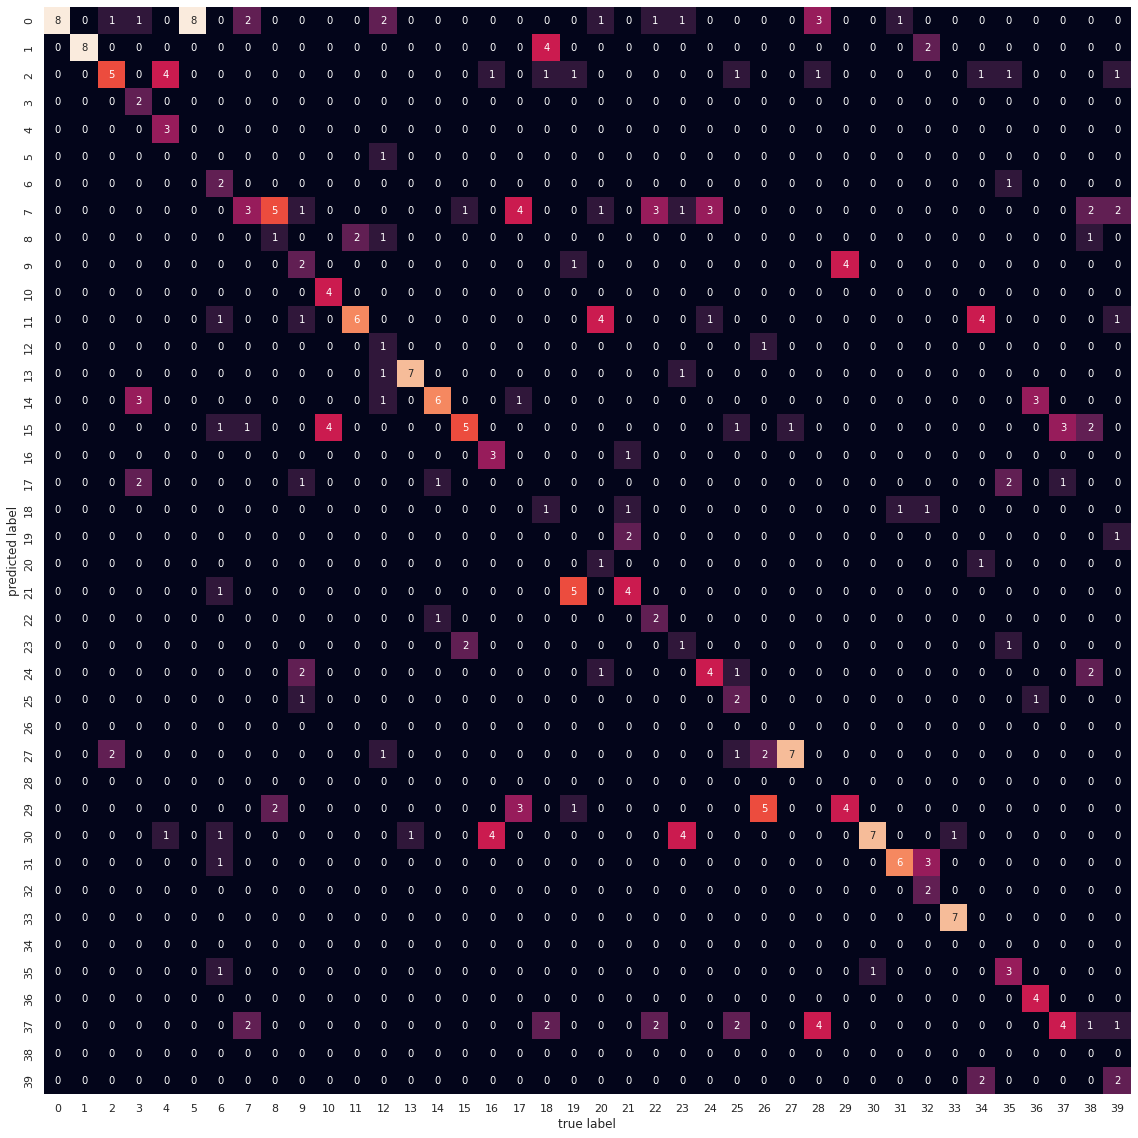

In [116]:
gen_confusion_matrix(y_test, y_pred)

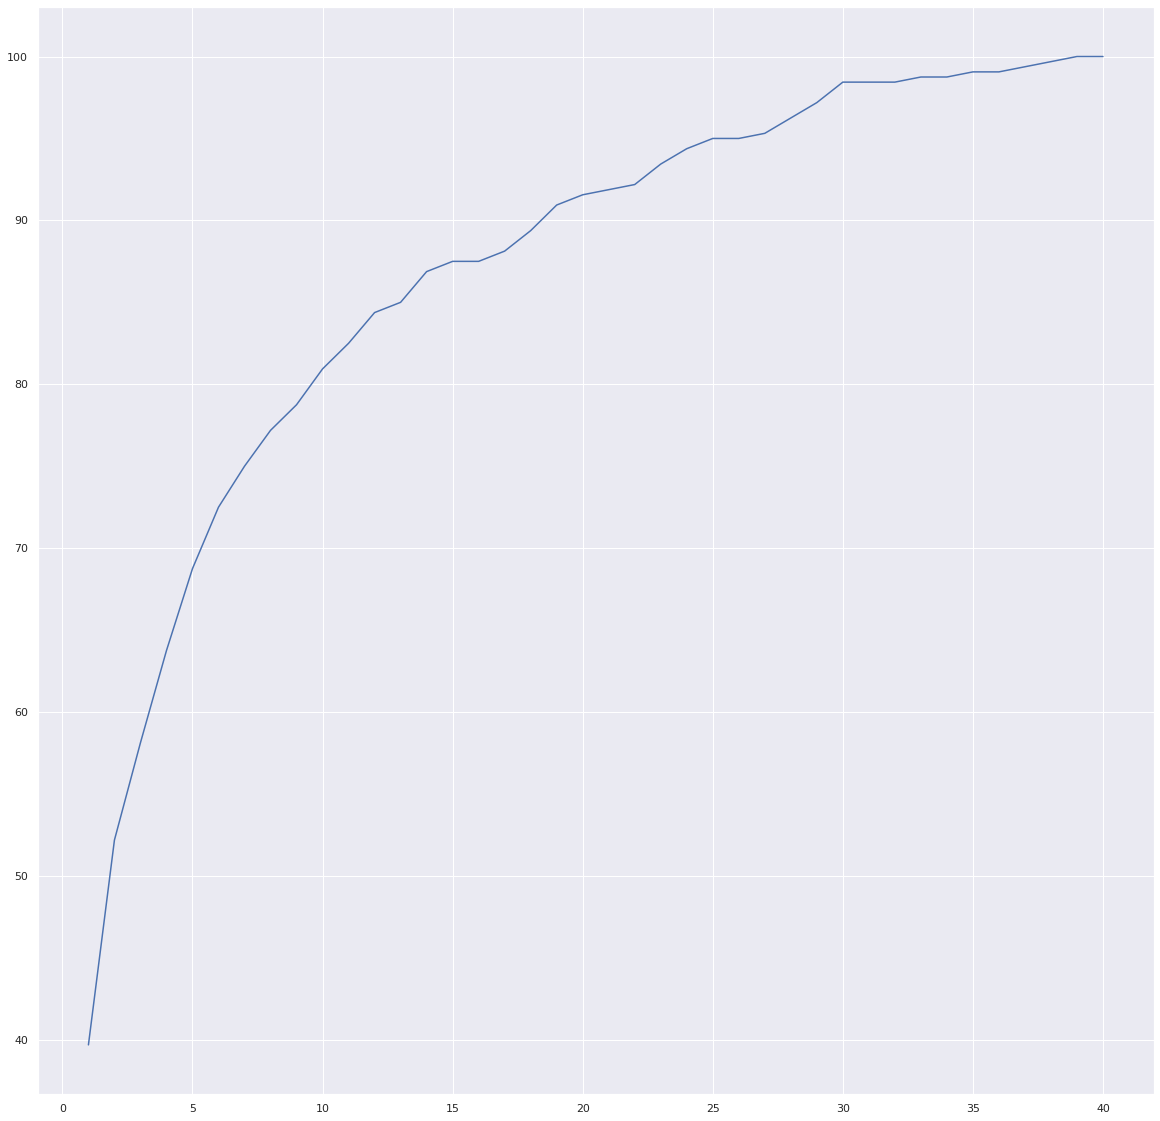

In [117]:
plot_CMC(y_fit, np.asarray(y_test))

**50% training, 50%testing**

**Split dataset**

In [118]:

X_train, y_train, X_test, y_test = split_dataset(50)

(200, 64, 64, 1) (200, 64, 64, 1)


**Create Model**

In [119]:
lenet_5_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu', input_shape=X_train[0].shape, padding='same'), 
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'), 
    keras.layers.AveragePooling2D(), 
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'), 
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(40, activation='relu'), 
    keras.layers.Dense(40, activation='softmax') #Output layer
])

**Compile and Build Model**

In [120]:
lenet_5_model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [121]:
lenet_5_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
7/7 [==============================] - 1s 142ms/step - loss: 3.6920 - accuracy: 0.0250 - val_loss: 3.6883 - val_accuracy: 0.0350
Epoch 2/40
7/7 [==============================] - 1s 119ms/step - loss: 3.6884 - accuracy: 0.0200 - val_loss: 3.6867 - val_accuracy: 0.0550
Epoch 3/40
7/7 [==============================] - 1s 121ms/step - loss: 3.6822 - accuracy: 0.0600 - val_loss: 3.6753 - val_accuracy: 0.0450
Epoch 4/40
7/7 [==============================] - 1s 118ms/step - loss: 3.6667 - accuracy: 0.0450 - val_loss: 3.6462 - val_accuracy: 0.0700
Epoch 5/40
7/7 [==============================] - 1s 120ms/step - loss: 3.6113 - accuracy: 0.0600 - val_loss: 3.6076 - val_accuracy: 0.0550
Epoch 6/40
7/7 [==============================] - 1s 121ms/step - loss: 3.5343 - accuracy: 0.0850 - val_loss: 3.4960 - val_accuracy: 0.0700
Epoch 7/40
7/7 [==============================] - 1s 121ms/step - loss: 3.3799 - accuracy: 0.0800 - val_loss: 3.3920 - val_accuracy: 0.0650
Epoch 8/40
7/7 [====

**Results**

In [122]:
y_fit = lenet_5_model.predict(X_test)
y_pred = y_fit.argmax(axis=1)

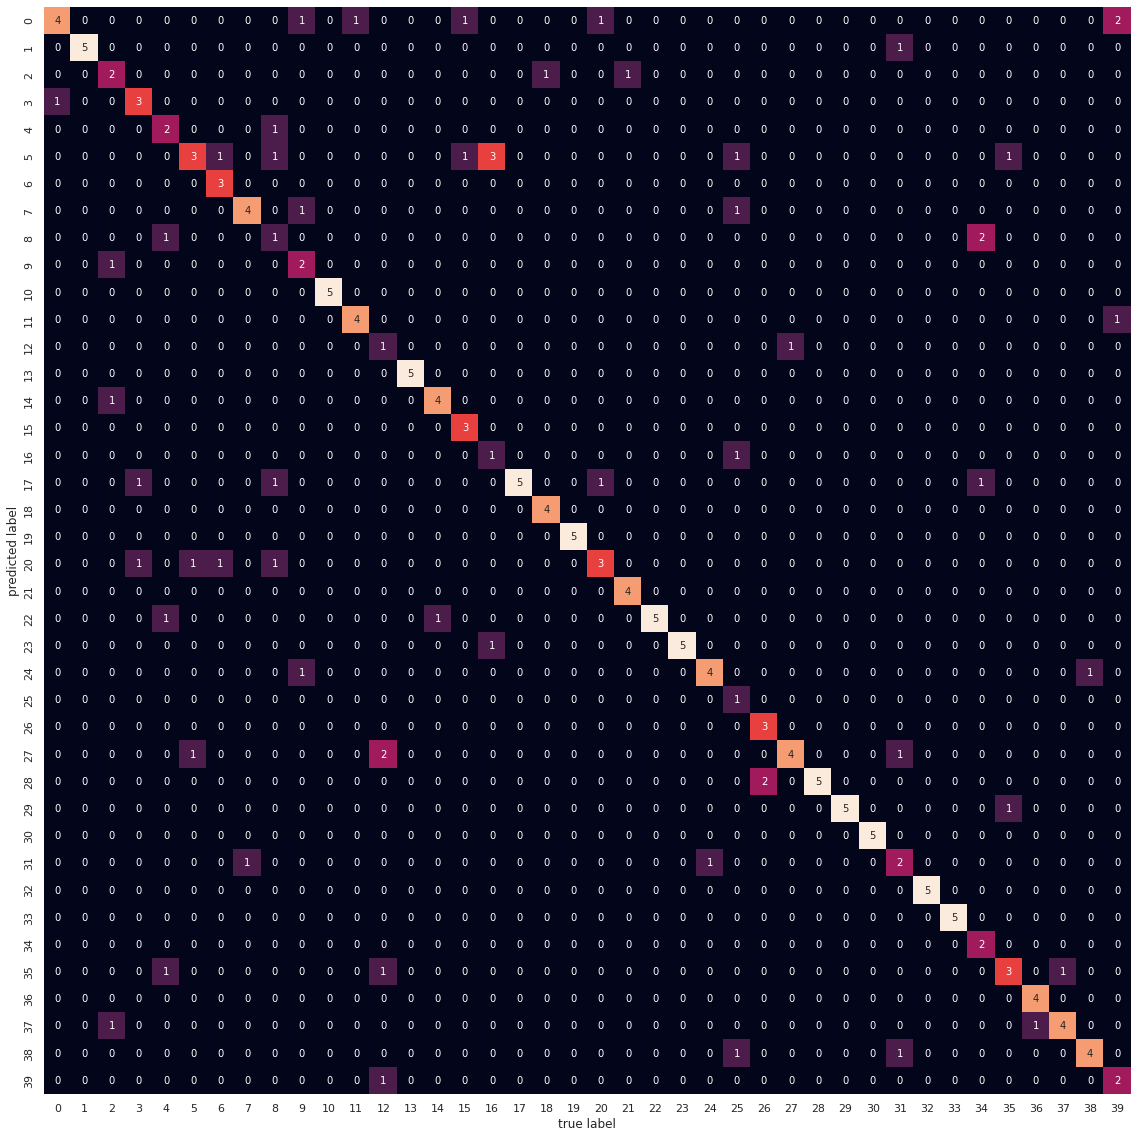

In [123]:
gen_confusion_matrix(y_test, y_pred)

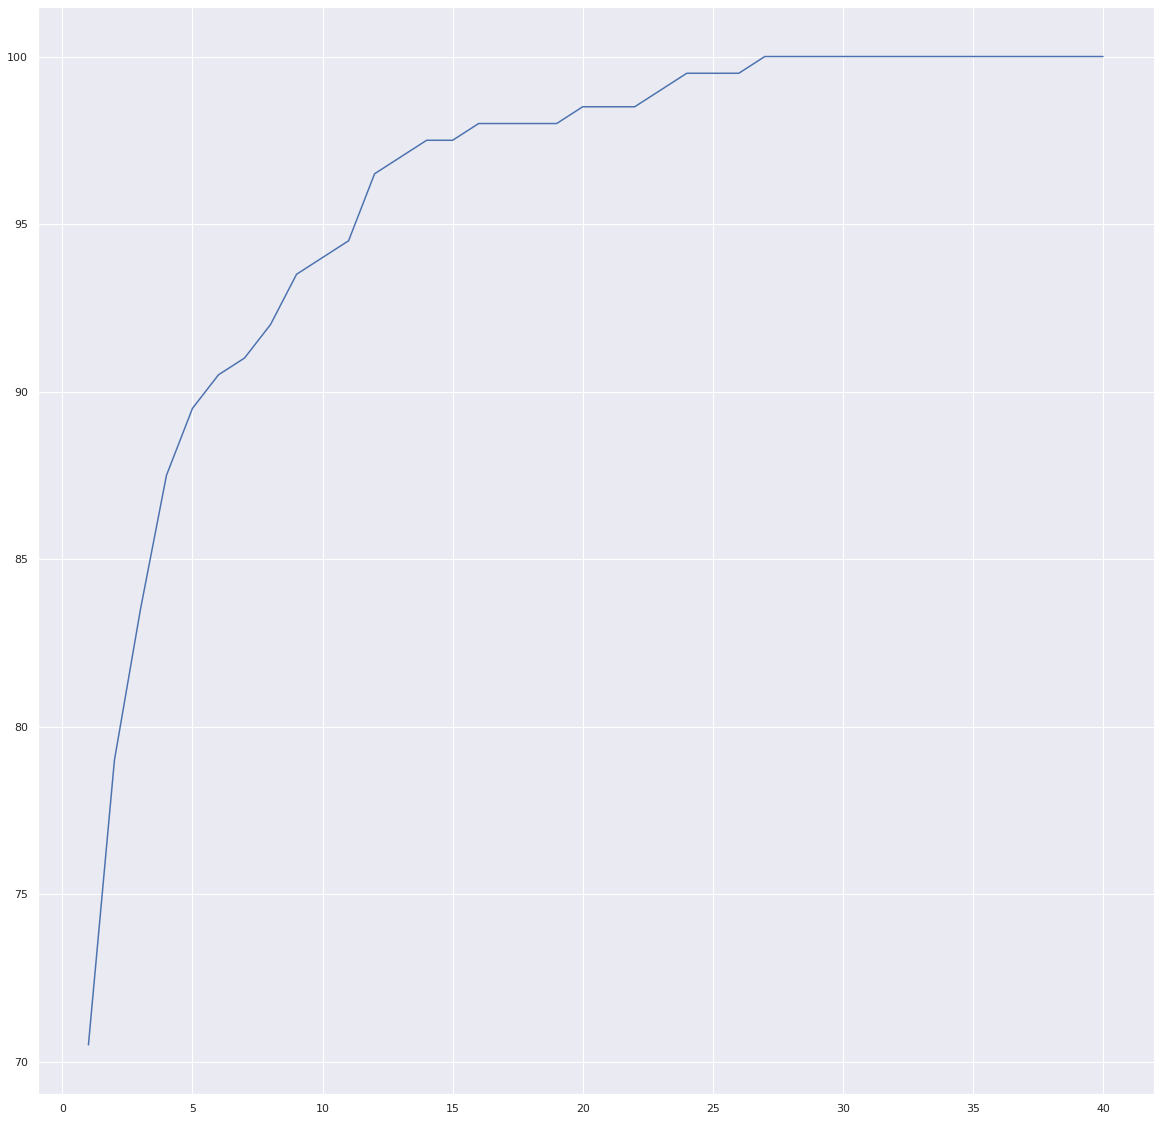

In [124]:
plot_CMC(y_fit, np.asarray(y_test))

**80% training, 20%testing**

**Split dataset**

In [125]:

X_train, y_train, X_test, y_test = split_dataset(80)

(320, 64, 64, 1) (80, 64, 64, 1)


**Create Model**

In [126]:
lenet_5_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu', input_shape=X_train[0].shape, padding='same'), 
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'), 
    keras.layers.AveragePooling2D(), 
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'), 
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(40, activation='relu'), 
    keras.layers.Dense(40, activation='softmax') #Output layer
])

**Compile and Build Model**

In [127]:
lenet_5_model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [128]:
lenet_5_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
10/10 [==============================] - 1s 113ms/step - loss: 3.7014 - accuracy: 0.0219 - val_loss: 3.6888 - val_accuracy: 0.0250
Epoch 2/40
10/10 [==============================] - 1s 101ms/step - loss: 3.6892 - accuracy: 0.0250 - val_loss: 3.6888 - val_accuracy: 0.0250
Epoch 3/40
10/10 [==============================] - 1s 102ms/step - loss: 3.6889 - accuracy: 0.0250 - val_loss: 3.6880 - val_accuracy: 0.0250
Epoch 4/40
10/10 [==============================] - 1s 100ms/step - loss: 3.6873 - accuracy: 0.0312 - val_loss: 3.6851 - val_accuracy: 0.0250
Epoch 5/40
10/10 [==============================] - 1s 99ms/step - loss: 3.6837 - accuracy: 0.0250 - val_loss: 3.6781 - val_accuracy: 0.0250
Epoch 6/40
10/10 [==============================] - 1s 100ms/step - loss: 3.6769 - accuracy: 0.0375 - val_loss: 3.6676 - val_accuracy: 0.0250
Epoch 7/40
10/10 [==============================] - 1s 102ms/step - loss: 3.6631 - accuracy: 0.0531 - val_loss: 3.6531 - val_accuracy: 0.0125
Epoch 8

**Results**

In [129]:
y_fit = lenet_5_model.predict(X_test)
y_pred = y_fit.argmax(axis=1)

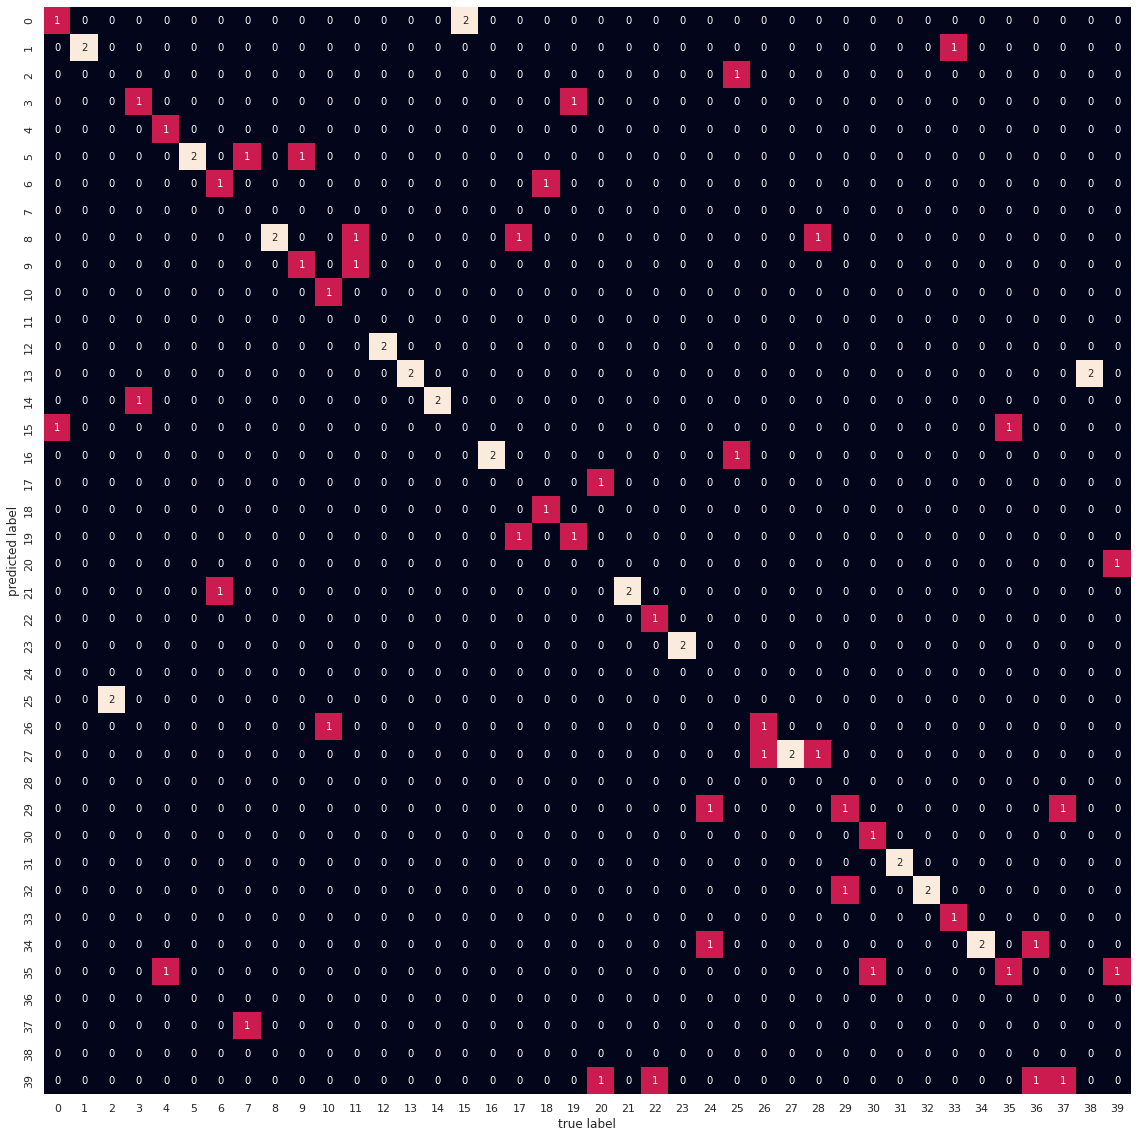

In [130]:
gen_confusion_matrix(y_test, y_pred)

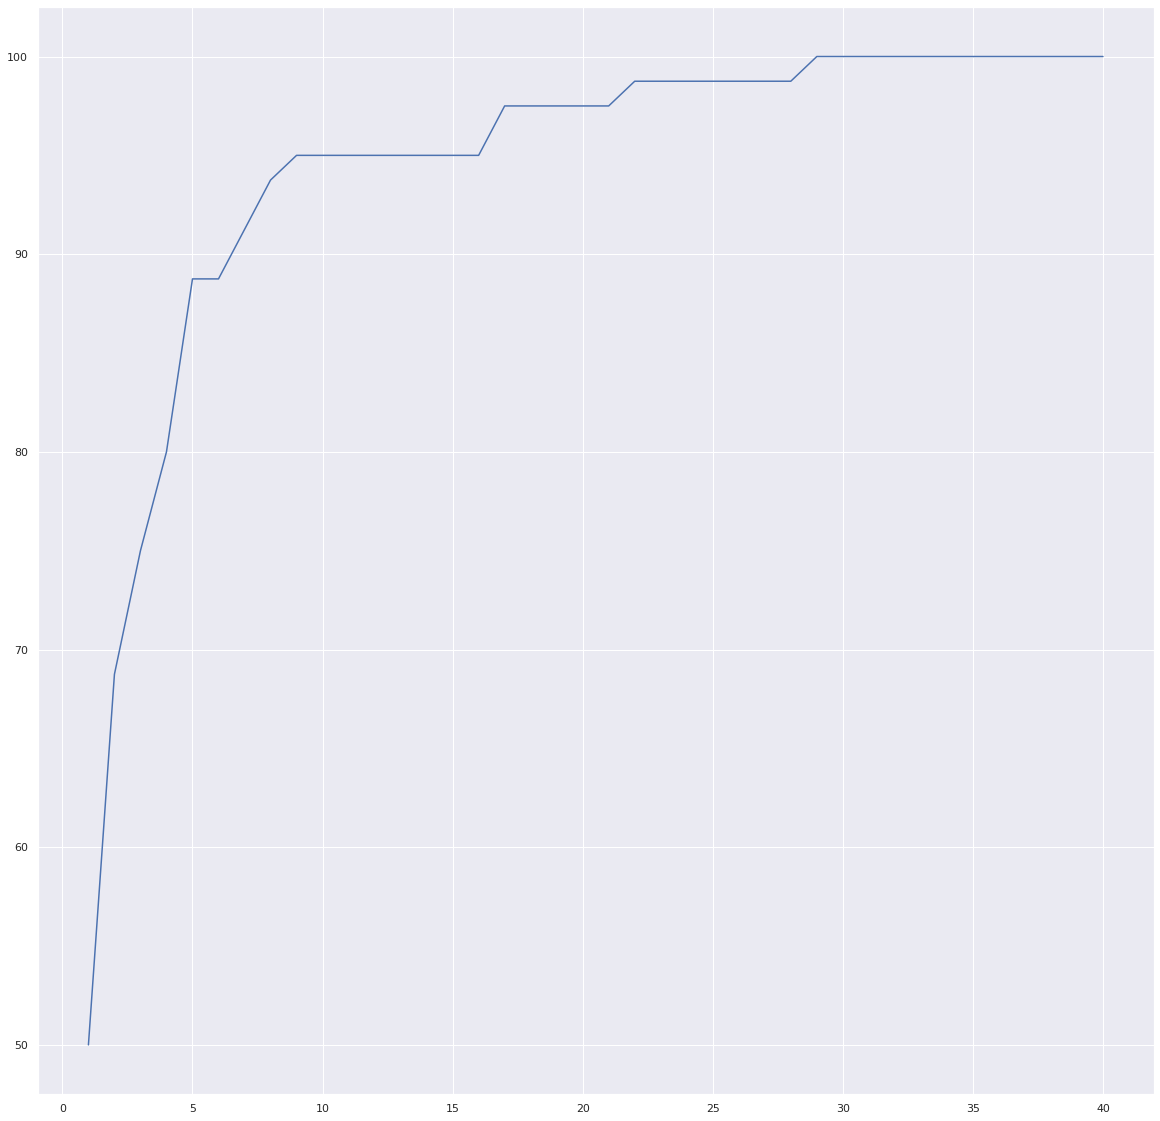

In [131]:
plot_CMC(y_fit, np.asarray(y_test))

**Is CNN better than PCA/LDA/SVM?**

Yes, CNN seems to have a better performance and greater accuracy than PCA, LDA and SVM

**Is there a clear difference in performance for different train/test data splits?**

Yes, as the ratio of test:train data increases, the accuracy of the model increases and at a faster rate

**Can data augmentation improve the results?**

Yes, data augmentation during training can ensure the network is more optimized and hence improve the results